In [72]:
import pandas as pd
import seaborn as sns
import warnings
sns.set(style="whitegrid", palette="muted", font_scale=1)
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

In [73]:
region = 'Midwest'

In [74]:
df = pd.read_csv(f'/Users/victoriashi/DataspellProjects/LTV_DataSci_Capstone_Project/VS_processed_region_data/{region}.csv', parse_dates=True, index_col='date')

In [75]:
df.head()

,county_fips,state_fips,state_name,covid_19_confirmed_cases,covid_19_deaths,social_distancing_total_grade,social_distancing_encounters_grade,social_distancing_travel_distance_grade,daily_state_test,precipitation,...,age_55_59,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_or_higher,immigrant_student_ratio,month,year
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,17001,17,Illinois,0.0,0.0,F,F,F,0.0,25.4,...,7,6,5,4,3,3,3,0.026503,1,2020
2020-01-23,17001,17,Illinois,0.0,0.0,F,F,F,0.0,45.2,...,7,6,5,4,3,3,3,0.026503,1,2020
2020-01-24,17001,17,Illinois,0.0,0.0,F,F,F,0.0,86.0,...,7,6,5,4,3,3,3,0.026503,1,2020
2020-01-25,17001,17,Illinois,0.0,0.0,F,F,F,0.0,30.0,...,7,6,5,4,3,3,3,0.026503,1,2020
2020-01-26,17001,17,Illinois,0.0,0.0,F,F,F,0.0,34.0,...,7,6,5,4,3,3,3,0.026503,1,2020


In [76]:
# df.info()
df.columns

Index(['county_fips', 'state_fips', 'state_name', 'covid_19_confirmed_cases',
       'covid_19_deaths', 'social_distancing_total_grade',
       'social_distancing_encounters_grade',
       'social_distancing_travel_distance_grade', 'daily_state_test',
       'precipitation', 'temperature', 'virus_pressure', 'total_population',
       'female_percent', 'area', 'population_density', 'latitude', 'longitude',
       'hospital_beds_ratio', 'ventilator_capacity_ratio', 'icu_beds_ratio',
       'houses_density', 'less_than_high_school_diploma',
       'high_school_diploma_only', 'some_college_or_higher',
       'total_college_population', 'percent_smokers', 'percent_diabetes',
       'Religious_congregation_ratio', 'political_party', 'airport_distance',
       'passenger_load_ratio', 'meat_plants', 'median_household_income',
       'percent_insured', 'deaths_per_100000', 'gdp_per_capita', 'age_0_4',
       'age_5_9', 'age_10_14', 'age_15_19', 'age_20_24', 'age_25_29',
       'age_30_34', 'age

Text(0.5, 0, 'Date')

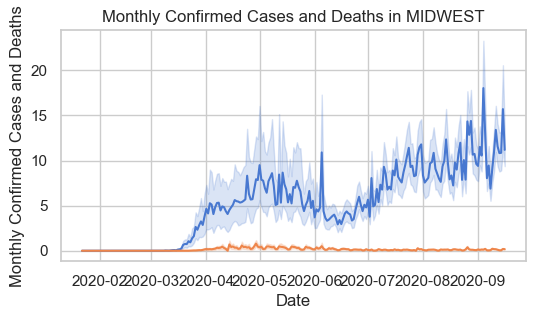

In [77]:
# plot monthly confirmed cases and deaths
sns.lineplot(x=df.index, y='covid_19_confirmed_cases', data=df)
# death
sns.lineplot(x=df.index, y='covid_19_deaths', data=df)
plt.title(f'Monthly Confirmed Cases and Deaths in {region.upper()}')
plt.ylabel('Monthly Confirmed Cases and Deaths')
plt.xlabel('Date')

### Check for Stationarity using ADF test

In [78]:
# find the daily confirmed case in the previous two weeks
# df['1D_cases'] = df['covid_19_confirmed_cases'].diff(periods=1)
df['1W_cases'] = df['covid_19_confirmed_cases'].diff(periods=7)
# df['2W_cases'] = df['covid_19_confirmed_cases'].diff(periods=14)
df.head()

,county_fips,state_fips,state_name,covid_19_confirmed_cases,covid_19_deaths,social_distancing_total_grade,social_distancing_encounters_grade,social_distancing_travel_distance_grade,daily_state_test,precipitation,...,age_60_64,age_65_69,age_70_74,age_75_79,age_80_84,age_85_or_higher,immigrant_student_ratio,month,year,1W_cases
date,,,,,,,,,,,,,,,,,,,,,
2020-01-22,17001,17,Illinois,0.0,0.0,F,F,F,0.0,25.4,...,6,5,4,3,3,3,0.026503,1,2020,NaN
2020-01-23,17001,17,Illinois,0.0,0.0,F,F,F,0.0,45.2,...,6,5,4,3,3,3,0.026503,1,2020,NaN
2020-01-24,17001,17,Illinois,0.0,0.0,F,F,F,0.0,86.0,...,6,5,4,3,3,3,0.026503,1,2020,NaN
2020-01-25,17001,17,Illinois,0.0,0.0,F,F,F,0.0,30.0,...,6,5,4,3,3,3,0.026503,1,2020,NaN
2020-01-26,17001,17,Illinois,0.0,0.0,F,F,F,0.0,34.0,...,6,5,4,3,3,3,0.026503,1,2020,NaN


In [ ]:
df.columns

In [ ]:
# arima model using arima auto
# drop apparanetly
df.drop(columns = ['county_fips', 'state_fips', 'state_name'], inplace=True)
df.head()

In [79]:
# use auto_arima() to predict the confirmed case next day using data df['1W_cases']
model = ARIMA(df['covid_19_confirmed_cases'], order=(1,2,0 ))
model_fit = model.fit()
# check model
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

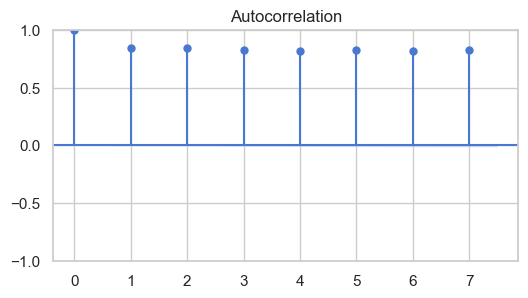

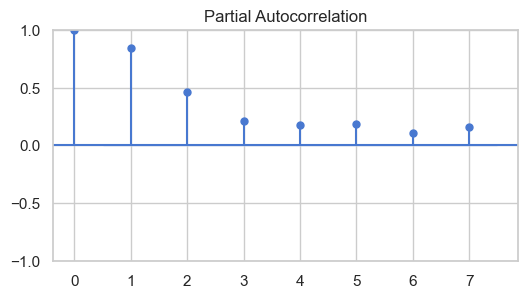

In [82]:
# plot the acf and pacf
plot_acf(df['covid_19_confirmed_cases'], lags=7)
plot_pacf(df['covid_19_confirmed_cases'], lags=7)
plt.show()

In [ ]:
from pmdarima.arima import auto_arima
# use auto_arima() to predict the confirmed case next day using dataa vailable one week before df['1W_cases']
ar1 = auto_arima(df['covid_19_confirmed_cases'], start_p=1, start_q=1,
           max_p=3, max_q=3, m=7,
           start_P=0, seasonal=True,
           d=1, D=1, trace=True,
           error_action='ignore',
           suppress_warnings=True,
           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=49.06 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1853640.880, Time=1.62 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=1744207.362, Time=14.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=25.33 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1798469.889, Time=2.01 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=1719968.387, Time=36.65 sec


In [ ]:
# find the best model
